# Исследование объявлений о продаже квартир

В вашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

[Введение](#beginning)

1. [Изучение общей информации](#start)


2. [Предобработка данных](#preprocessing)


3. [Расчёт и добавление в таблицу новых столбцов](#columns)


4. [Проведение исследовательского анализа](#analysis)

    4.1. [Изучение параметров цены, площади, числа комнат, высоты потолков](#parametres)
    
    4.2. [Изучение времени продажи квартир](#exposition)   
    
    4.3. [Ценообразующие факторы](#pricing)  
    
    4.4. [Цены по населённым пунктам](#localty) 
    
    4.5. [Квартиры в центре города](#centre) 
 
 
5. [Общий вывод](#summary)  


<a id="beginning"></a>
### Введение

В ходе данной работы будут определены факторы, влияющие на рыночную цену объектов недвижимости, в том числе и в элитном сегменте; а также редкие и выбывающие значения параметров.

<a id="start"></a>
### 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem() 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [2]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [5]:
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
15937,11,3550000.0,74.00,2018-04-02T00:00:00,2,NaN,9.0,NaN,7,NaN,...,NaN,NaN,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,45.0
9422,3,5794000.0,87.30,2017-03-21T00:00:00,3,2.75,23.0,50.20,4,NaN,...,11.40,2.0,Санкт-Петербург,21928.0,17256.0,0.0,NaN,1.0,429.0,211.0
16151,20,9500000.0,87.00,2016-03-18T00:00:00,4,NaN,5.0,60.00,2,NaN,...,9.00,1.0,Санкт-Петербург,16678.0,6758.0,1.0,367.0,0.0,NaN,312.0
1477,0,3900000.0,56.80,2018-01-05T00:00:00,2,NaN,18.0,NaN,7,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
2010,1,5000000.0,75.00,2017-12-05T00:00:00,3,3.00,5.0,47.90,1,NaN,...,10.60,NaN,Санкт-Петербург,18492.0,15646.0,2.0,114.0,1.0,113.0,206.0
10172,20,11750000.0,110.00,2017-06-15T00:00:00,4,3.20,5.0,79.00,3,NaN,...,12.00,1.0,Санкт-Петербург,26125.0,4973.0,0.0,NaN,1.0,363.0,662.0
14365,8,5250000.0,66.00,2018-12-13T00:00:00,2,2.70,20.0,40.00,17,NaN,...,11.00,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
18642,2,3055000.0,35.65,2018-11-21T00:00:00,1,NaN,17.0,16.66,12,NaN,...,9.62,NaN,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,27.0
7023,16,22500000.0,150.30,2017-09-11T00:00:00,3,NaN,12.0,109.00,10,NaN,...,28.00,NaN,Санкт-Петербург,30827.0,6473.0,1.0,738.0,1.0,788.0,134.0
6707,8,3700000.0,32.00,2018-03-24T00:00:00,1,2.60,14.0,NaN,9,NaN,...,NaN,NaN,Санкт-Петербург,35788.0,10596.0,1.0,665.0,1.0,693.0,41.0


##### Вывод:
В таблице присутстсвуют пропущенные значения, которые необходимо будет заполнить.
Плюс, в неудобном формате представлена дата.

<a id="preprocessing"></a>
### 2. Предобработка данных

Рассмотрим данные по столбцам для заполнения пропусков, обработки некорректных значений и изменения типа данных на наиболее подходящий для удобства представления и экономии места.

In [6]:
print('Названия столбцов')
data.columns

Названия столбцов


Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

2.1. В столбце ****total_images**** нет пропущенных и некорректных значений. Тип данных int64. Можно заменить на uint8

In [7]:
data['total_images'] = data['total_images'].astype('uint8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

2.2. В столбце ****last_price**** нет пропущенных значений. Корректность значений проверим при расчёте средней цены. Тип данных float64 подходит для стоимости квартиры.

2.3. В столбце ****total_area**** нет пропущенных значений. Тип данных float64 подходит для площади квартиры.

2.4. В столбце ****first_day_exposition**** нет пропущенных значений. Однако необходимо перевести значения в этом столбце в читаемый формат даты.

In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


2.5. В столбце ****rooms**** нет пропущенных значений. Однако необходимо будет проверить, все ли нули - это квартиры-студии, а также сгруппировать многокомнатные квартиры в одну группу. Тип данных int64. Можно заменить на uint8.

In [9]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

In [10]:
data['rooms'] = data['rooms'].astype('uint8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

2.6. В столбце ****ceiling_height**** 9195 пропущенных значений. Тип данных float64 подходит. Выведем квартиры с площадью потолка более 6 метров (от 3 до 6 метров могут быть двухэтажные квартиры). Значения более 6 метров явно некорректны, как и значения менее 2,3 метров.

In [11]:
print(data['ceiling_height'].isnull().sum())

9195


In [12]:
data.query('ceiling_height > 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,NaN,...,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,8.3,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0


In [13]:
data.query('ceiling_height < 2.3')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.0,33.50,2017-03-30,1,2.00,15.0,17.500000,6,NaN,...,6.50,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000.0,62.00,2018-12-27,3,2.00,5.0,40.000000,4,NaN,...,6.00,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,1,2120000.0,35.43,2017-12-18,1,2.00,18.0,16.600000,9,NaN,...,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5712,5,1500000.0,42.80,2017-08-14,2,1.20,2.0,27.500000,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000.0,35.50,2018-05-29,1,2.00,5.0,NaN,5,NaN,...,NaN,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000.0,36.00,2017-06-18,1,2.00,17.0,15.200000,12,NaN,...,10.10,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
12755,2,1400000.0,22.50,2017-09-21,1,2.20,2.0,18.000000,2,NaN,...,4.50,1.0,село Копорье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16446,6,12300000.0,88.30,2019-03-12,3,2.00,5.0,63.900000,2,NaN,...,12.00,NaN,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
16884,0,1500000.0,33.00,2018-10-03,1,2.00,5.0,20.000000,5,False,...,6.00,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
16934,5,4100000.0,40.00,2017-10-17,1,1.75,37.0,17.400000,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0


Значения от 24 до 35 вызываны ошибкой ввода. Если их разделить на 10, т.е. сдвинуть запятую, проблема будет решена. Остальные выдающиеся значения пока обнулим.
Напишем функцию для описанных выше замен:

In [14]:
def ceiling(height):
    
        if (24 <= height < 35):
                return (height/10)
        else:
            if height > 6:
                return np.nan 
            if height < 2.3:
                return np.nan
            else:
                return height

Проверим корректность работы функции:

In [15]:
print(ceiling(24)) 
print(ceiling(34))
print(ceiling(2.4)) 
print(ceiling(8)) 
print(ceiling(2.2)) 

2.4
3.4
2.4
nan
nan


Применим функцию к нашим данным:

In [16]:
data['ceiling_height_new'] = data['ceiling_height'].apply(ceiling)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

In [17]:
data.query('ceiling_height_new > 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_new


В столбце ceiling_height_new не осталось значений свыше 6м. Заменим столбец ceiling_height на новосформированный. И удалим ненужный.

In [18]:
data['ceiling_height'] = data['ceiling_height_new']
del data['ceiling_height_new']
data.head(5) 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [19]:
data['ceiling_height'].describe()

count    14479.000000
mean         2.727327
std          0.277970
min          2.300000
25%          2.520000
50%          2.650000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

Получившиеся и изначальные значения NaN в столбце ceiling_height заменим на медианные.

In [20]:
ceiling_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_median)

In [21]:
print(data.info())
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


2.7. В столбце ****floors_total**** есть небольшое количество (87) пропущенных значений. Т.к. в дальнейшем в работе будем считать, что квартиры, у которых пропущено значение общего количества этажей, находятся не на последнем этаже, сейчас заполним столбец floors_total значениями столбца floor+1.

In [22]:
data['floors_total'].value_counts()

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
60.0       1
33.0       1
52.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64

In [23]:
data['floors_total'] = data['floors_total'].fillna(data['floor']+1)
print(data['floors_total'].value_counts())

5.0     5798
9.0     3769
16.0    1379
12.0    1365
4.0     1204
10.0    1179
25.0    1077
6.0      918
17.0     833
3.0      670
7.0      601
14.0     556
18.0     506
24.0     470
8.0      394
2.0      386
15.0     367
23.0     353
19.0     342
22.0     290
20.0     274
13.0     235
11.0     206
27.0     164
21.0     160
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
60.0       1
33.0       1
52.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64


Тип данных можно заменить на uint8

In [24]:
data['floors_total'] = data['floors_total'].astype('uint8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

2.8. В столбце ****living_area**** есть пропущенные значения. На средние будем уже заменять после вычисления отношения жилой площади к общей в новом столбце. 

2.9. В столбце ****floor**** нет пропущенных и нереальных значений. Тип данных можно заменить на uint8

In [25]:
data['floor'].value_counts()

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
33       1
29       1
30       1
32       1
31       1
Name: floor, dtype: int64

In [26]:
data['floor'] = data['floor'].astype('uint8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

2.9. В столбце ****is_apartment**** большинство значений - NaN, их можно заменить на False, т.к. в противном случае должно быть указано True. Используем для этого метод fillna

In [27]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_arou

In [28]:
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

2.10. В столбцах ****studio**** и ****open_plan**** нет пропущенных значений

2.11. В столбце ****kitchen**** пропущенные значения будем заполнять уже после расчёта отношения к общей площади.

2.12. В столбце ****balcony**** пропуски возникли по причине того, что не были указаны балконы при их фактическом отсутствии. Для дальнейших расчётов удобно заполнить нулями, что и сделаем методом fillna.

In [29]:
print(data['balcony'].value_counts())

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64


In [30]:
data['balcony'] = data['balcony'].fillna(0)
print(data['balcony'].value_counts())

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64


Тип данных в столбце balcony можно заменить на uint8.

In [31]:
data['balcony'] = data['balcony'].astype('uint8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around

2.13. Для заполнения пропусков в столбце ****locality_name**** построим сводную таблицу по локациям и определим максимальное расстояние до центра города, при котором объект ещё можно отнести к Санкт-Петербургу.

In [32]:
data.pivot_table(index=['locality_name'], values='cityCenters_nearest', aggfunc=['mean','min', 'max'])

,mean,min,max
,cityCenters_nearest,cityCenters_nearest,cityCenters_nearest
locality_name,,,
Зеленогорск,54617.583333,51115.0,62706.0
Колпино,32113.771513,29436.0,37477.0
Красное Село,30020.284091,27317.0,41792.0
Кронштадт,49195.726316,46657.0,51511.0
Ломоносов,50739.969697,36816.0,61495.0
Павловск,33206.921053,31533.0,36445.0
Петергоф,35468.925373,29815.0,49574.0
Пушкин,28745.375000,24311.0,35610.0


In [33]:
data['locality_name'].value_counts()

Санкт-Петербург           15721
посёлок Мурино              522
посёлок Шушары              440
Всеволожск                  398
Пушкин                      369
                          ...  
поселок Красносельское        1
деревня Лаврики               1
посёлок Дзержинского          1
поселок Сумино                1
посёлок Мыза-Ивановка         1
Name: locality_name, Length: 364, dtype: int64

Т.к. в данном столбце для нас имеет значение только деление на СПб/пригороды, применим следующую замену: при расстоянии до центра менее 29500, будем считать объект расположенным в СПб; более - в пригороде.

In [34]:
data['locality_name'] = data['locality_name'].fillna(0)

In [35]:
def localization(row):
    cityCenters_nearest = row['cityCenters_nearest']
    locality_name = row['locality_name']
    if locality_name == 0:
        if cityCenters_nearest < 29500:
            return 'Санкт-Петербург'
        else:
            return 'пригород'
    else:
        return locality_name

Проверим, как работает функция и применим функцию к нашим данным:

In [36]:
row_values = [29000, 0]
row_columns = ['cityCenters_nearest', 'locality_name']
row = pd.Series(data=row_values, index=row_columns)
print(localization(row))

row_values = [30000, 0]
row_columns = ['cityCenters_nearest', 'locality_name']
row = pd.Series(data=row_values, index=row_columns)
print(localization(row))

row_values = [29000, 'Шушары']
row_columns = ['cityCenters_nearest', 'locality_name']
row = pd.Series(data=row_values, index=row_columns)
print(localization(row))

Санкт-Петербург
пригород
Шушары


In [37]:
data['locality_name'] = data.apply(localization, axis = 1)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around

In [39]:
data.query('locality_name == "пригород"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2033,6,5398000.0,80.0,2017-05-30,3,2.65,4,42.6,2,False,...,18.6,0,пригород,NaN,NaN,NaN,NaN,NaN,NaN,34.0
8986,10,4850000.0,103.1,2018-07-10,3,2.65,5,68.1,4,False,...,16.7,0,пригород,19659.0,31813.0,0.0,NaN,0.0,NaN,28.0
14342,3,3611000.0,53.5,2017-04-27,1,2.65,4,25.8,3,False,...,NaN,1,пригород,NaN,NaN,NaN,NaN,NaN,NaN,92.0
17535,2,5985000.0,79.8,2018-07-30,3,2.65,9,NaN,2,False,...,NaN,0,пригород,NaN,NaN,NaN,NaN,NaN,NaN,213.0
20382,8,1750000.0,72.9,2018-10-27,3,2.65,5,47.3,2,False,...,8.3,0,пригород,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20590,7,3380000.0,56.0,2017-11-06,2,2.70,4,29.0,3,False,...,10.0,1,пригород,NaN,NaN,NaN,NaN,NaN,NaN,78.0
21119,8,3500000.0,43.2,2018-11-11,2,2.65,4,NaN,2,False,...,NaN,0,пригород,19744.0,31897.0,0.0,NaN,0.0,NaN,9.0
21276,0,17122148.0,178.3,2017-02-10,1,2.65,3,NaN,1,False,...,41.6,1,пригород,60195.0,41294.0,0.0,NaN,0.0,NaN,4.0
21715,2,6047550.0,80.1,2018-07-30,2,2.65,9,30.5,2,False,...,29.2,0,пригород,NaN,NaN,NaN,NaN,NaN,NaN,176.0
21898,2,5886750.0,83.5,2018-07-30,2,2.65,9,36.6,2,False,...,29.7,0,пригород,NaN,NaN,NaN,NaN,NaN,NaN,169.0


2.15. В столбце ****days_exposition**** заполним пропуски на медианные значения и переведём в формат uint16.

In [40]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [41]:
exposition_median = data['days_exposition'].median()
data['days_exposition'] = data['days_exposition'].fillna(exposition_median)
data['days_exposition'] = data['days_exposition'].astype('uint16')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around

2.16. В столбцах ****parks_around3000 и ponds_around3000**** пропущенные значения заполним на нули, т.к. пропуски означают, что рядом парков/прудов нет. Тип данных заменим на uint8

In [43]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype('uint8')
data['ponds_around3000'] = data['ponds_around3000'].astype('uint8')

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null uint8
parks_nearest           8079 non-null float64
ponds_around30

2.17. Посмотрим, все ли пропущенные значения в столбце ****parks_nearest**** имеют нули в столбце parks_around3000:

In [45]:
parks_null = data[data['parks_nearest'].isnull() == True]
parks_null['parks_around3000'].describe()

count    15620.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: parks_around3000, dtype: float64

Наше предположение верно: данные в столбце parks_nearest не заполнены, т.к. парков в радиусе 3000 м нет. Можно заполнить эти пропущенные значения на 4000, а тип данных заменить на uint16

In [46]:
data['parks_nearest'] = data['parks_nearest'].fillna(4000)
data['parks_nearest'] = data['parks_nearest'].astype('uint16')

2.18. Также и для столбца ****ponds_nearest**** проверим, все ли пропущенные значения имеют нули в столбце ponds_around3000:

In [47]:
ponds_null = data[data['ponds_nearest'].isnull() == True]
ponds_null['ponds_around3000'].describe()

count    14589.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: ponds_around3000, dtype: float64

Наше предположение верно: данные в столбце ponds_nearest не заполнены, т.к. прудов в радиуса 3000 м нет. Можно заполнить эти пропущенные значения на 4000, а тип данных заменить на uint16

In [48]:
data['ponds_nearest'] = data['ponds_nearest'].fillna(4000)
data['ponds_nearest'] = data['ponds_nearest'].astype('uint16')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around30

2.19. Проверим, есть ли строки со значением True в столбце ****studio****, но имеющие при этом ненулевую комнатность. Эти данные нужно привести в соответствие: везде, где есть значение True, указать нулевую комнатность. И наоборот, везде, где комнат ноль, указать значение True в столбце studio. По этому типу квартир при указании комнатности на рынке недвижимости часто возникают расхождения.

In [49]:
pd.options.display.max_columns = None
studios = data.query('studio == True')
studios['rooms'].describe()

count    149.000000
mean       0.073826
std        0.262369
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: rooms, dtype: float64

In [50]:
rooms0 = data.query('rooms == 0')
rooms0['studio'].value_counts()

True     138
False     59
Name: studio, dtype: int64

In [51]:
data.pivot_table(index=['rooms', 'studio'], values='total_area', aggfunc=['count'])

count
             total_area
rooms studio           
0     False          59
      True          138
1     False        8036
      True           11
2     False        7940
3     False        5814
4     False        1180
5     False         326
6     False         105
7     False          59
8     False          12
9     False           8
10    False           3
11    False           2
12    False           1
14    False           2
15    False           1
16    False           1
19    False           1

Напишем 2 функции:
- для замены значений в столбце rooms на нули при True в столбце studio;
- для замены значений в столбце studio на True при нулях в столбце rooms.
Затем проверим корректность работы функций и применим к нашим данным.

In [52]:
def studization(row):
    rooms = row['rooms']
    studio = row['studio']
    if studio == True:
        return 0
    else:
        return rooms

In [53]:
row_values = [0, True]
row_columns = ['rooms', 'studio']
row = pd.Series(data=row_values, index=row_columns)
print(studization(row))

row_values = [2, True]
row_columns = ['rooms', 'studio']
row = pd.Series(data=row_values, index=row_columns)
print(studization(row))

row_values = [3, False]
row_columns = ['rooms', 'studio']
row = pd.Series(data=row_values, index=row_columns)
print(studization(row))

0
0
3


In [54]:
data['rooms'] = data.apply(studization, axis = 1)

In [55]:
def studization2(row):
    rooms = row['rooms']
    studio = row['studio']
    if rooms == 0:
        return True
    else:
        return False

In [56]:
row_values = [0, False]
row_columns = ['rooms', 'studio']
row = pd.Series(data=row_values, index=row_columns)
print(studization2(row))

row_values = [2, False]
row_columns = ['rooms', 'studio']
row = pd.Series(data=row_values, index=row_columns)
print(studization2(row))


True
False


In [57]:
data['studio'] = data.apply(studization2, axis = 1)

In [58]:
data.pivot_table(index=['rooms', 'studio'], values='total_area', aggfunc=['count'])

,,count
,,total_area
rooms,studio,
0,True,208
1,False,8036
2,False,7940
3,False,5814
4,False,1180
5,False,326
6,False,105
7,False,59


Тип данных в столбце rooms можно заменить на uint8

In [59]:
data['rooms'] = data['rooms'].astype('uint8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around30

2.20. Пропуски в столбцах ****airports_nearest и cityCenters_nearest**** можно заполнить исходя из медианных значений расстояний до аэропорта/центра города по населённым пунктам.

In [60]:
data_without_nan_airport = data[data['airports_nearest'].isna() != True]
data_without_nan_airport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18157 entries, 0 to 23697
Data columns (total 22 columns):
total_images            18157 non-null uint8
last_price              18157 non-null float64
total_area              18157 non-null float64
first_day_exposition    18157 non-null datetime64[ns]
rooms                   18157 non-null uint8
ceiling_height          18157 non-null float64
floors_total            18157 non-null uint8
living_area             16879 non-null float64
floor                   18157 non-null uint8
is_apartment            18157 non-null bool
studio                  18157 non-null bool
open_plan               18157 non-null bool
kitchen_area            16596 non-null float64
balcony                 18157 non-null uint8
locality_name           18157 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18156 non-null float64
parks_around3000        18157 non-null uint8
parks_nearest           18157 non-null uint16
ponds_around30

In [61]:
data_grouped_airport = data_without_nan_airport.groupby('locality_name').agg({'airports_nearest': ['median', 'mean']})
data_grouped_airport.columns = ['median_airport', 'mean_airport']
print(data_grouped_airport)

                         median_airport  mean_airport
locality_name                                        
Зеленогорск                     72282.0  73300.250000
Колпино                         26232.0  26375.863501
Красное Село                    25715.5  26595.579545
Кронштадт                       67850.0  67469.263158
Ломоносов                       48415.5  48308.280303
Павловск                        20529.5  21053.342105
Петергоф                        39231.0  40184.676617
Пушкин                          15766.0  16447.869919
Санкт-Петербург                 26726.0  28036.113053
Сестрорецк                      56692.0  56640.486339
поселок Лисий Нос               55930.0  55930.000000
поселок Мурино                  51553.0  51553.000000
посёлок Александровская         12896.5  12896.500000
посёлок Белоостров              57769.0  57769.000000
посёлок Левашово                52693.0  52693.000000
посёлок Лисий Нос               54988.5  54988.500000
посёлок Металлострой        

In [62]:
new_data = data.join(data_grouped_airport, on = 'locality_name')
new_data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_airport,mean_airport
11662,0,3890000.0,45.3,2017-09-27,2,2.65,9,28.00,2,False,False,False,7.0,2,Санкт-Петербург,32642.0,10882.0,2,522,0,4000,50,26726.0,28036.113053
3719,8,3100000.0,48.8,2017-05-12,1,2.65,6,28.90,1,False,False,False,12.1,0,Санкт-Петербург,22774.0,3082.0,1,286,3,155,80,26726.0,28036.113053
20638,2,6600000.0,75.0,2018-02-12,3,3.20,5,55.50,1,False,False,False,6.0,0,Санкт-Петербург,40371.0,9455.0,2,195,0,4000,64,26726.0,28036.113053
15437,4,6177643.0,77.7,2019-02-13,3,2.70,20,49.98,18,False,False,False,NaN,0,Санкт-Петербург,37364.0,8322.0,2,309,2,706,35,26726.0,28036.113053
13852,5,3286000.0,40.3,2017-12-15,1,2.65,26,NaN,8,False,False,False,NaN,0,посёлок Парголово,52726.0,18900.0,0,4000,0,4000,39,53426.0,53994.926606
16747,1,3740000.0,31.0,2019-03-01,1,2.70,9,18.00,9,False,False,False,6.0,0,Санкт-Петербург,45624.0,19195.0,0,4000,0,4000,24,26726.0,28036.113053
17320,0,1720000.0,42.0,2017-12-09,2,2.65,5,24.00,4,False,False,False,6.5,1,городской посёлок Мга,NaN,NaN,0,4000,0,4000,45,NaN,NaN
1593,13,3490000.0,32.0,2018-01-04,1,2.70,5,18.20,5,False,False,False,5.5,1,Санкт-Петербург,14133.0,8382.0,0,4000,0,4000,164,26726.0,28036.113053
1710,13,1050000.0,30.4,2018-02-07,1,2.65,2,17.50,1,False,False,False,6.1,0,городской посёлок Мга,NaN,NaN,0,4000,0,4000,210,NaN,NaN
14476,9,4000000.0,45.7,2018-10-03,2,2.50,9,28.20,5,False,False,False,8.2,1,Санкт-Петербург,36574.0,10889.0,1,661,0,4000,6,26726.0,28036.113053


Для удобства заменим значения NaN в столбце airports_nearest на -1. И напишем функцию для замены пропущенных значений на медианные по локациям. Для пригородов, у которых нет данных для группы, будем использовать среднее значение для пригорода.
Тип значений в столбце можно заменить на uint32

In [63]:
new_data['airports_nearest'] = new_data['airports_nearest'].fillna(-1)
new_data['median_airport'] = new_data['median_airport'].fillna(33200)

In [64]:
def airportization(row):
    airports_nearest = row['airports_nearest']
    median_airport = row['median_airport']
    if airports_nearest == -1:
        return median_airport
    else:
        return airports_nearest

In [65]:
row_values = [-1, 16000]
row_columns = ['airports_nearest', 'median_airport']
row = pd.Series(data=row_values, index=row_columns)
print(airportization(row))

row_values = [10000, 16000]
row_columns = ['airports_nearest', 'median_airport']
row = pd.Series(data=row_values, index=row_columns)
print(airportization(row))

16000
10000


In [66]:
new_data['airports_nearest'] = new_data.apply(airportization, axis = 1)
new_data['airports_nearest'] = new_data['airports_nearest'].astype('uint32')
del new_data['median_airport']
del new_data['mean_airport']
data = new_data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        23699 non-null uint32
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around300

То же самое проделаем для столбца cityCenters_nearest

In [67]:
data_without_nan_centre = data[data['cityCenters_nearest'].isna() != True]
data_without_nan_centre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18180 entries, 0 to 23697
Data columns (total 22 columns):
total_images            18180 non-null uint8
last_price              18180 non-null float64
total_area              18180 non-null float64
first_day_exposition    18180 non-null datetime64[ns]
rooms                   18180 non-null uint8
ceiling_height          18180 non-null float64
floors_total            18180 non-null uint8
living_area             16900 non-null float64
floor                   18180 non-null uint8
is_apartment            18180 non-null bool
studio                  18180 non-null bool
open_plan               18180 non-null bool
kitchen_area            16617 non-null float64
balcony                 18180 non-null uint8
locality_name           18180 non-null object
airports_nearest        18180 non-null uint32
cityCenters_nearest     18180 non-null float64
parks_around3000        18180 non-null uint8
parks_nearest           18180 non-null uint16
ponds_around300

In [68]:
data_grouped_centre = data_without_nan_centre.groupby('locality_name').agg({'cityCenters_nearest': ['median', 'mean']})
data_grouped_centre.columns = ['median_centre', 'mean_centre']
print(data_grouped_centre)

                         median_centre   mean_centre
locality_name                                       
Зеленогорск                    53381.0  54617.583333
Колпино                        32018.0  32113.771513
Красное Село                   29140.5  30020.284091
Кронштадт                      49575.0  49195.726316
Ломоносов                      51677.0  50739.969697
Павловск                       32683.0  33206.921053
Петергоф                       33771.0  35468.925373
Пушкин                         27930.5  28745.375000
Санкт-Петербург                12242.0  11595.977640
Сестрорецк                     34821.0  34624.480874
поселок Лисий Нос              28246.0  28246.000000
поселок Мурино                 21888.0  21888.000000
посёлок Александровская        27468.0  27468.000000
посёлок Белоостров             38868.0  38868.000000
посёлок Левашово               25727.0  25727.000000
посёлок Лисий Нос              27297.0  27297.000000
посёлок Металлострой           27602.0  27561.

In [69]:
new_data2 = data.join(data_grouped_centre, on = 'locality_name')
new_data2.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_centre,mean_centre
2291,6,27000000.0,173.60,2015-06-11,5,3.30,5,125.50,4,False,False,False,15.00,1,Санкт-Петербург,21776,399.0,2,65,3,562,388,12242.0,11595.977640
18512,10,5290000.0,51.40,2018-11-02,2,2.70,16,28.70,4,False,False,False,10.20,0,Санкт-Петербург,14339,11901.0,0,4000,0,4000,112,12242.0,11595.977640
15719,9,2290000.0,33.00,2016-12-03,1,2.65,9,16.60,7,False,False,False,8.80,1,Красное Село,27895,31320.0,1,596,0,4000,365,29140.5,30020.284091
15787,7,2800000.0,37.00,2017-01-25,1,2.50,9,18.00,6,False,False,False,8.00,2,Ломоносов,46910,50335.0,0,4000,2,362,135,51677.0,50739.969697
14295,4,500000.0,34.00,2016-02-09,1,2.65,5,17.00,4,False,False,False,8.00,1,поселок городского типа Никольский,33200,NaN,0,4000,0,4000,724,NaN,NaN
19715,5,11700000.0,119.60,2018-09-04,4,3.20,6,NaN,2,False,False,False,NaN,0,Санкт-Петербург,25442,4017.0,1,510,0,4000,67,12242.0,11595.977640
23226,10,4000000.0,40.00,2018-02-01,1,2.65,17,20.00,2,False,False,False,10.00,0,Санкт-Петербург,33465,14563.0,0,4000,1,399,85,12242.0,11595.977640
2317,20,4800000.0,37.19,2018-12-17,1,2.65,25,14.59,7,False,False,False,10.72,2,Санкт-Петербург,43288,12045.0,0,4000,0,4000,95,12242.0,11595.977640
707,7,4500000.0,40.20,2017-08-08,1,2.70,27,11.00,4,False,False,False,14.20,2,посёлок Парголово,53115,19292.0,0,4000,1,593,65,19311.0,19924.776758
23075,4,6029433.0,77.80,2019-01-29,3,2.70,21,49.98,6,False,False,False,NaN,0,Санкт-Петербург,37364,8322.0,2,309,2,706,21,12242.0,11595.977640


Для удобства заменим значения NaN в столбце cityCenters_nearest на -1. И напишем функцию для замены пропущенных значений на медианные по локациям. Для пригородов, у которых нет данных для группы, будем использовать среднее значение для пригорода.
Тип значений в столбце можно заменить на uint32

In [70]:
new_data2['cityCenters_nearest'] = new_data2['cityCenters_nearest'].fillna(-1)
new_data2['median_centre'] = new_data2['median_centre'].fillna(35000)

In [71]:
def centrization(row):
    cityCenters_nearest = row['cityCenters_nearest']
    median_centre = row['median_centre']
    if cityCenters_nearest == -1:
        return median_centre
    else:
        return cityCenters_nearest

In [72]:
row_values = [-1, 16000]
row_columns = ['cityCenters_nearest', 'median_centre']
row = pd.Series(data=row_values, index=row_columns)
print(centrization(row))

row_values = [20000, 16000]
row_columns = ['cityCenters_nearest', 'median_centre']
row = pd.Series(data=row_values, index=row_columns)
print(centrization(row))

16000
20000


In [73]:
new_data2['cityCenters_nearest'] = new_data2.apply(centrization, axis = 1)
new_data2['cityCenters_nearest'] = new_data2['cityCenters_nearest'].astype('uint32')
del new_data2['median_centre']
del new_data2['mean_centre']
data = new_data2
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null uint8
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        23699 non-null uint32
cityCenters_nearest     23699 non-null uint32
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around3000

In [74]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,21796.000000,23699.000000,21421.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,9.858475,6.541549e+06,60.348651,2.070172,2.697243,10.675092,34.457852,5.892358,10.569807,0.591080,29846.275159,18957.592430,0.469049,2803.713659,0.590911,2661.496519,169.360226
std,5.682529,1.088701e+07,35.654083,1.079081,0.220515,6.595719,22.030445,4.885249,5.905438,0.959298,11287.074722,11544.317336,0.748534,1675.399156,0.883999,1702.607065,206.535633
min,0.000000,1.219000e+04,12.000000,0.000000,2.300000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,21151.000000,10927.000000,0.000000,601.000000,0.000000,637.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,33200.000000,14951.000000,0.000000,4000.000000,0.000000,4000.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,34496.500000,34156.500000,1.000000,4000.000000,1.000000,4000.000000,199.000000
max,50.000000,7.630000e+08,900.000000,19.000000,6.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,4000.000000,3.000000,4000.000000,1580.000000


#### Вывод:
Были заполнены пропуски во всех столбцах, кроме столбцов с жилой площадью и площадью кухни.
Их мы сможем заполнить после расчёта отношения этих величин к общей площади.
Типы данных во всех остальных столбцах также заменены на наиболее подходящие.
Также были скорректированы нереальные значения потолков.

<a id="columns"></a>
### 3. Расчёт и добавление в таблицу новых столбцов

Добавим в таблицу столбец ***price_per_metre*** (цена квадратного метра) и зададим ему тип данных uint32

In [75]:
data['price_per_metre'] = data['last_price']/data['total_area']

In [76]:
data['price_per_metre'] = data['price_per_metre'].astype('uint32')
data['last_price'] = data['last_price'].astype('uint32')


In [77]:
data['price_per_metre'].describe()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [78]:
data['last_price'].describe()

count       23699.000
mean      6541548.772
std      10887013.268
min         12190.000
25%       3400000.000
50%       4650000.000
75%       6800000.000
max     763000000.000
Name: last_price, dtype: float64

Добавим в таблицу столбец с номером ***дня недели*** публикации объявления и зададим ему тип данных uint8

In [79]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday'] = data['weekday'].astype('uint8')

Добавим в таблицу столбец с ***годом публикации*** объявления и зададим ему тип данных uint16

In [80]:
data['year'] = data['first_day_exposition'].dt.year
data['year'] = data['year'].astype('uint16')

Добавим в таблицу столбец с ***месяцем публикации*** объявления и зададим ему тип данных uint8

In [81]:
data['month'] = data['first_day_exposition'].dt.month
data['month'] = data['month'].astype('uint8')

Добавим в таблицу столбец с ***этажом квартиры***: первый, последний или другой.

In [82]:
data['floor_type'] = data['floor'].where(data['floor'] != 1, 'Первый')

In [83]:
data['floor_type'] = data['floor_type'].where(data['floor'] != data['floors_total'], 'Последний')

In [84]:
data['floor_type'] = data['floor_type'].where(data['floor_type'].isin(('Первый', 'Последний')), 'Другой')

Добавим в таблицу также закодированный столбец ***floor_type_kode*** для удобства расчётов, где Первый - 1, Последний -3, а Другой - 2

In [85]:
data['floor_type_kode'] = data['floor_type'].where(data['floor_type'] != 'Первый', 1)
data['floor_type_kode'] = data['floor_type_kode'].where(data['floor_type_kode'] != 'Последний', 3)
data['floor_type_kode'] = data['floor_type_kode'].where(data['floor_type_kode'] != 'Другой', 2)
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode
10614,17,3900000,41.900,2017-10-31,1,2.650,19,18.900,9,False,False,False,11.500,2,Санкт-Петербург,37636,14479,0,4000,1,1127,17,93078,1,2017,10,Другой,2
3890,12,4100000,57.000,2017-08-25,3,2.650,5,40.000,1,False,False,False,6.000,1,Санкт-Петербург,16614,16537,0,4000,1,192,84,71929,4,2017,8,Первый,1
15941,19,2000000,33.400,2017-09-05,1,2.500,5,18.200,3,False,False,False,6.300,0,поселок городского типа Синявино,33200,35000,0,4000,0,4000,101,59880,1,2017,9,Другой,2
8243,6,4070000,36.300,2018-09-26,1,2.650,25,17.100,7,False,False,False,10.400,2,Санкт-Петербург,23776,25406,0,4000,1,471,37,112121,2,2018,9,Другой,2
9597,2,15000000,116.000,2017-04-14,4,3.300,20,90.000,20,False,False,False,19.200,5,Санкт-Петербург,39357,10581,2,288,3,311,68,129310,4,2017,4,Последний,3
20331,20,13700000,106.500,2019-04-05,3,2.630,5,71.000,5,False,False,False,9.600,0,Санкт-Петербург,53724,16995,0,4000,2,325,95,128638,4,2019,4,Последний,3
18186,8,2850000,106.000,2016-05-29,5,2.600,5,76.000,2,False,False,False,9.000,0,посёлок городского типа Сиверский,33200,35000,0,4000,0,4000,812,26886,6,2016,5,Другой,2
19316,5,7100000,94.000,2015-03-29,3,2.650,17,47.000,2,False,False,False,12.000,5,Санкт-Петербург,17390,16804,1,172,0,4000,491,75531,6,2015,3,Другой,2
22287,14,4700000,78.000,2017-09-28,4,2.500,9,54.500,6,False,False,False,10.000,0,Колпино,24925,30711,0,4000,0,4000,349,60256,3,2017,9,Другой,2
5016,11,12000000,115.100,2018-02-27,4,2.930,4,70.900,4,False,False,False,16.100,0,Санкт-Петербург,22037,3440,0,4000,0,4000,90,104257,1,2018,2,Последний,3


In [86]:
data['floor_type_kode'] = data['floor_type_kode'].astype('uint8')

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
total_images            23699 non-null uint8
last_price              23699 non-null uint32
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        23699 non-null uint32
cityCenters_nearest     23699 non-null uint32
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around3000 

Добавим в таблицу столбцы с ***соотношением жилой площади к общей и площади кухни к общей площади квартиры***

In [88]:
data['living_area_to_all'] = data['living_area']/data['total_area']
data['kitchen_area_to_all'] = data['kitchen_area']/data['total_area']

In [89]:
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all
16618,4,7500000,110.600,2017-04-21,5,3.070,7,76.500,4,False,False,False,13.400,0,Санкт-Петербург,24148,3690,0,4000,0,4000,252,67811,4,2017,4,Другой,2,0.692,0.121
18748,11,2580000,46.600,2017-07-09,3,2.500,5,32.400,1,False,False,False,5.100,0,Кировск,33200,35000,0,4000,0,4000,327,55364,6,2017,7,Первый,1,0.695,0.109
22579,6,3400000,32.000,2018-06-23,1,2.700,16,15.000,1,False,False,False,6.000,0,Санкт-Петербург,14809,13606,0,4000,0,4000,162,106250,5,2018,6,Первый,1,0.469,0.188
21792,15,13900000,101.400,2018-07-26,3,2.970,4,68.100,3,False,False,False,18.600,0,Санкт-Петербург,15163,10969,0,4000,1,585,200,137080,3,2018,7,Другой,2,0.672,0.183
22927,20,10800000,67.800,2019-02-26,2,2.800,12,37.000,7,False,False,False,16.000,0,Санкт-Петербург,40806,12509,2,182,0,4000,28,159292,1,2019,2,Другой,2,0.546,0.236


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
total_images            23699 non-null uint8
last_price              23699 non-null uint32
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             21796 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        23699 non-null uint32
cityCenters_nearest     23699 non-null uint32
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around3000 

Теперь можно заполнить ***пропуски в столбцах living_area и kitchen_area*** исходя из медианного соотношения этих площадей к общей по типам квартир. Для начала посмотрим, сколько квартир какого типа попало в данные.

In [91]:
data.pivot_table(index=['rooms'], values='total_area', aggfunc=['count'])

,count
,total_area
rooms,
0,208
1,8036
2,7940
3,5814
4,1180
5,326
6,105
7,59


In [92]:
data.pivot_table(index=['rooms'], values='total_area', aggfunc=['min', 'max', 'median', 'mean'])

,min,max,median,mean
,total_area,total_area,total_area,total_area
rooms,,,,
0,15.500,371.000,26.075,29.180
1,12.000,494.100,36.600,37.659
2,20.000,196.000,53.000,55.855
3,40.100,363.100,73.000,77.765
4,42.000,500.000,99.300,107.611
5,40.000,507.000,146.450,161.475
6,87.000,500.000,184.300,201.538
7,100.600,631.200,214.000,265.325


Создадим новый столбец ***rooms_new***, где сгруппируем квартры 5 и более комнат в новую группу 5. Такую группировку произведём, т.к. именно она принята в отрасли. И исходя из количества квартир в каждой группе, а также опираясь на их площади.

In [93]:
data['rooms_new'] = data['rooms'].where(data['rooms'].isin((0, 1, 2, 3, 4)), 5)

In [94]:
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new
8605,4,2600000,28.000,2016-03-09,1,2.650,20,19.500,14,False,False,False,4.000,0,поселок Мурино,51553,21888,0,4000,0,4000,137,92857,2,2016,3,Другой,2,0.696,0.143,1
5715,11,10450000,110.000,2017-07-13,3,3.500,4,70.000,2,False,False,False,17.000,0,Санкт-Петербург,21711,1826,2,628,1,78,285,95000,3,2017,7,Другой,2,0.636,0.155,3
12985,7,2250000,24.500,2017-04-14,1,2.650,22,14.000,18,False,False,False,nan,0,посёлок Мурино,33200,35000,0,4000,0,4000,40,91836,4,2017,4,Другой,2,0.571,nan,1
13565,16,1700000,51.500,2018-03-03,2,2.500,5,28.000,2,False,False,False,7.200,0,деревня Тойворово,33200,35000,0,4000,0,4000,95,33009,5,2018,3,Другой,2,0.544,0.140,2
19566,0,2180000,28.500,2017-08-10,1,2.650,12,18.000,7,False,False,False,nan,0,посёлок Мурино,33200,35000,0,4000,0,4000,53,76491,3,2017,8,Другой,2,0.632,nan,1
3107,3,3350000,36.000,2017-07-07,1,2.650,13,15.500,7,False,False,False,11.000,0,Санкт-Петербург,17755,16576,0,4000,1,594,45,93055,4,2017,7,Другой,2,0.431,0.306,1
8125,20,7700000,58.500,2019-04-02,2,3.230,6,34.200,5,False,False,False,7.900,0,Санкт-Петербург,21869,4087,0,4000,0,4000,95,131623,1,2019,4,Другой,2,0.585,0.135,2
17276,7,3650000,38.200,2017-04-20,1,2.600,12,20.000,12,False,False,False,10.000,2,Санкт-Петербург,14539,13335,0,4000,0,4000,92,95549,3,2017,4,Последний,3,0.524,0.262,1
15366,18,5200000,57.000,2018-02-01,2,2.550,12,32.000,4,False,False,False,8.000,2,Санкт-Петербург,51425,14437,1,651,0,4000,172,91228,3,2018,2,Другой,2,0.561,0.140,2
6044,11,3500000,56.600,2018-08-07,3,2.500,5,42.000,4,False,False,False,5.000,1,Красное Село,27637,31062,0,4000,0,4000,59,61837,1,2018,8,Другой,2,0.742,0.088,3


Определим медианные значения ***living_area_to_all*** по типам квартир и осуществим замену пропущенных значений в этом столбце на медианные по типам квартир.

In [95]:
data_without_nan_living = data[data['living_area'].isna() != True]

In [96]:
data_grouped_living = data_without_nan_living.pivot_table(index=['rooms_new'], values='living_area_to_all', aggfunc=['min', 'max', 'median', 'mean'])
data_grouped_living.columns = ['min_living', 'max_living', 'median_living', 'mean_living']
data_grouped_living

,min_living,max_living,median_living,mean_living
rooms_new,,,,
0,0.087,1.000,0.689,0.686
1,0.073,0.976,0.482,0.486
2,0.038,0.957,0.585,0.579
3,0.022,0.972,0.632,0.625
4,0.070,0.908,0.660,0.646
5,0.179,0.983,0.661,0.649


In [97]:
new_data3 = data.join(data_grouped_living, on = 'rooms_new')

In [98]:
new_data3['living_area_to_all'] = new_data3['living_area_to_all'].fillna(new_data3['median_living'])
new_data3[new_data3['living_area'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,min_living,max_living,median_living,mean_living
3,0,64900000,159.000,2015-07-24,3,2.650,14,nan,9,False,False,False,nan,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,4,2015,7,Другой,2,0.632,nan,3,0.022,0.972,0.632,0.625
7,5,7915000,71.600,2019-04-18,2,2.650,24,nan,22,False,False,False,18.900,2,Санкт-Петербург,23982,11634,0,4000,0,4000,95,110544,3,2019,4,Другой,2,0.585,0.264,2,0.038,0.957,0.585,0.579
30,12,2200000,32.800,2018-02-19,1,2.650,9,nan,2,False,False,False,nan,0,Коммунар,33200,35000,0,4000,0,4000,63,67073,0,2018,2,Другой,2,0.482,nan,1,0.073,0.976,0.482,0.486
37,10,1990000,45.800,2017-10-28,2,2.500,5,nan,1,False,False,False,nan,0,поселок городского типа Красный Бор,33200,35000,0,4000,0,4000,196,43449,5,2017,10,Первый,1,0.585,nan,2,0.038,0.957,0.585,0.579
44,13,5350000,40.000,2018-11-18,1,2.650,22,nan,3,False,False,False,nan,1,Санкт-Петербург,30471,11603,1,620,1,1152,95,133750,6,2018,11,Другой,2,0.482,nan,1,0.073,0.976,0.482,0.486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000,80.300,2018-07-03,3,2.700,12,nan,5,False,False,False,nan,0,Колпино,27933,33719,0,4000,2,562,60,74097,1,2018,7,Другой,2,0.632,nan,3,0.022,0.972,0.632,0.625
23663,12,6400000,88.000,2018-01-12,4,2.550,10,nan,1,False,False,False,nan,0,Санкт-Петербург,33642,13943,0,4000,2,844,59,72727,4,2018,1,Первый,1,0.660,nan,4,0.070,0.908,0.660,0.646
23670,9,2450000,45.600,2018-02-08,1,2.800,9,nan,2,False,False,False,nan,0,поселок городского типа Синявино,33200,35000,0,4000,0,4000,45,53728,3,2018,2,Другой,2,0.482,nan,1,0.073,0.976,0.482,0.486
23679,0,2500000,35.000,2017-12-08,1,2.650,9,nan,4,False,False,False,nan,0,Сосновый Бор,33200,35000,0,4000,0,4000,45,71428,4,2017,12,Другой,2,0.482,nan,1,0.073,0.976,0.482,0.486


Рассчитаем пропущенные значения для столбца ***living_area*** исходя из полученных значений living_area_to_all по группам квартир.

In [99]:
new_data3['living_area'] = new_data3['total_area'] * new_data3['living_area_to_all']
new_data3.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,min_living,max_living,median_living,mean_living
20740,13,4150000,66.400,2018-11-25,3,2.500,7,43.000,5,False,False,False,9.000,0,Выборг,33200,35000,0,4000,0,4000,19,62499,6,2018,11,Другой,2,0.648,0.136,3,0.022,0.972,0.632,0.625
22603,5,7610814,68.300,2016-10-29,2,2.700,11,32.200,7,False,False,False,16.500,0,Санкт-Петербург,23609,5299,0,4000,1,433,727,111432,5,2016,10,Другой,2,0.471,0.242,2,0.038,0.957,0.585,0.579
2220,10,16800000,84.000,2019-04-17,3,3.750,4,58.000,2,False,False,False,10.000,0,Санкт-Петербург,20504,3619,3,474,1,689,95,200000,2,2019,4,Другой,2,0.690,0.119,3,0.022,0.972,0.632,0.625
8628,0,8000000,48.900,2018-02-23,1,2.650,6,23.587,4,False,False,False,nan,0,Санкт-Петербург,26726,5735,2,110,0,4000,60,163599,4,2018,2,Другой,2,0.482,nan,1,0.073,0.976,0.482,0.486
1114,0,4800000,40.000,2018-10-13,1,2.650,16,20.000,15,False,False,False,9.000,2,Санкт-Петербург,30571,11470,1,721,0,4000,20,120000,5,2018,10,Другой,2,0.500,0.225,1,0.073,0.976,0.482,0.486


In [100]:
del new_data3['min_living']
del new_data3['max_living']
del new_data3['median_living']
del new_data3['mean_living']
data = new_data3

In [101]:
data[data['living_area'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new


Проделаем то же самое для пропущенных значений в столбцах ***kitchen_area и kitchen_area_to_all***

In [102]:
data_without_nan_kitchen = data[data['kitchen_area'].isna() != True]

In [103]:
data_grouped_kitchen = data_without_nan_kitchen.pivot_table(index=['rooms_new'], values='kitchen_area_to_all', aggfunc=['min', 'max', 'median', 'mean'])
data_grouped_kitchen.columns = ['min_kitchen', 'max_kitchen', 'median_kitchen', 'mean_kitchen']
data_grouped_kitchen

,min_kitchen,max_kitchen,median_kitchen,mean_kitchen
rooms_new,,,,
1,0.046,0.788,0.248,0.250
2,0.044,0.657,0.161,0.174
3,0.043,0.715,0.129,0.141
4,0.047,0.500,0.112,0.124
5,0.025,0.348,0.102,0.107


In [104]:
new_data4 = data.join(data_grouped_kitchen, on = 'rooms_new')

Для квартир-студий в таблице не указана площадь кухни, т.к. комната с кухней объединены. Для них будем считать, что площадь кухни составляет 0,4 от общей площади.

In [105]:
new_data4['kitchen_area_to_all'] = new_data4['kitchen_area_to_all'].fillna(new_data4['median_kitchen'])
new_data4['kitchen_area_to_all'] = new_data4['kitchen_area_to_all'].fillna(0.4)
new_data4[new_data4['kitchen_area_to_all'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,min_kitchen,max_kitchen,median_kitchen,mean_kitchen


Рассчитаем пропущенные значения для столбца kitchen_area исходя из полученных значений kitchen_area_to_all по группам квартир.

In [106]:
new_data4['kitchen_area'] = new_data4['total_area'] * new_data4['kitchen_area_to_all']
new_data4.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,min_kitchen,max_kitchen,median_kitchen,mean_kitchen
14557,8,3700000,45.000,2017-06-20,2,2.500,5,21.000,4,False,False,False,7.300,0,Петергоф,45547,48972,0,4000,0,4000,45,82222,1,2017,6,Другой,2,0.467,0.162,2,0.044,0.657,0.161,0.174
21658,3,2960000,38.060,2018-01-01,1,2.650,17,15.910,14,False,False,False,11.220,2,поселок Бугры,33200,35000,0,4000,0,4000,59,77771,0,2018,1,Другой,2,0.418,0.295,1,0.046,0.788,0.248,0.250
22578,11,4650000,63.260,2017-02-07,3,2.650,9,46.010,2,False,False,False,6.280,0,Санкт-Петербург,49080,14905,1,239,1,609,64,73506,1,2017,2,Другой,2,0.727,0.099,3,0.043,0.715,0.129,0.141
6486,20,3100000,41.300,2016-07-01,2,2.500,5,26.000,5,False,False,False,6.800,0,Санкт-Петербург,40450,11382,2,173,0,4000,54,75060,4,2016,7,Последний,3,0.630,0.165,2,0.044,0.657,0.161,0.174
7981,5,2690000,31.000,2017-10-31,1,2.650,5,17.000,3,False,False,False,6.000,0,Санкт-Петербург,15865,15769,0,4000,2,974,68,86774,1,2017,10,Другой,2,0.548,0.194,1,0.046,0.788,0.248,0.250


In [107]:
new_data4[new_data4['kitchen_area'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,min_kitchen,max_kitchen,median_kitchen,mean_kitchen


In [108]:
del new_data4['min_kitchen']
del new_data4['max_kitchen']
del new_data4['median_kitchen']
del new_data4['mean_kitchen']
data = new_data4

In [109]:
data[data['kitchen_area'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 31 columns):
total_images            23699 non-null uint8
last_price              23699 non-null uint32
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null uint8
ceiling_height          23699 non-null float64
floors_total            23699 non-null uint8
living_area             23699 non-null float64
floor                   23699 non-null uint8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null uint8
locality_name           23699 non-null object
airports_nearest        23699 non-null uint32
cityCenters_nearest     23699 non-null uint32
parks_around3000        23699 non-null uint8
parks_nearest           23699 non-null uint16
ponds_around3000 

#### Вывод:
в таблицу добавлены расчётные столбцы цены за м2, этажа квартиры(первый/последний), дня недели, года, месяца публикации объявления, соотношения общей и жилой площади,которые в дальнейшем будут использованы для анализа данных.
А также уже были использованы для заполнения пропусков в столбцах с жилой площадью и площадью кухни.

<a id="analysis"></a>
### 4. Проведение исследовательского анализа данных:

<a id="parametres"></a>
#### 4.1. Изучение параметров цены, площади, числа комнат, высоты потолков

Построим гистограмму для площади квартир:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e69f67090>]],
      dtype=object)

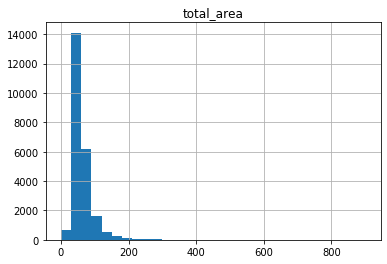

In [111]:
data.hist('total_area', bins = 30, range=(0, 900))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e6a862710>]],
      dtype=object)

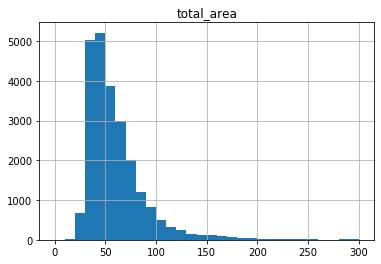

In [112]:
data.hist('total_area', bins = 30, range=(0, 300))

In [113]:
data.pivot_table(index=['rooms_new'], values='total_area', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,total_area,total_area,total_area,total_area
rooms_new,,,,
0,15.500,371.000,26.075,29.180
1,12.000,494.100,36.600,37.659
2,20.000,196.000,53.000,55.855
3,40.100,363.100,73.000,77.765
4,42.000,500.000,99.300,107.611
5,40.000,900.000,165.000,189.855
All,12.000,900.000,52.000,60.349


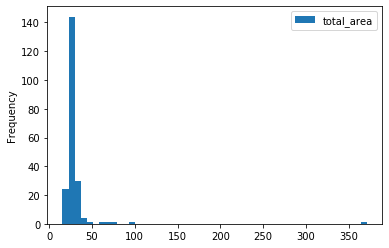

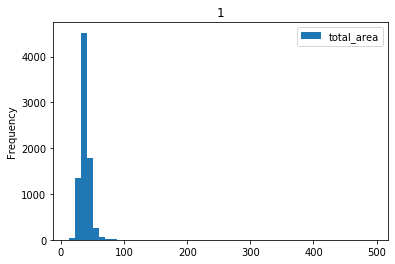

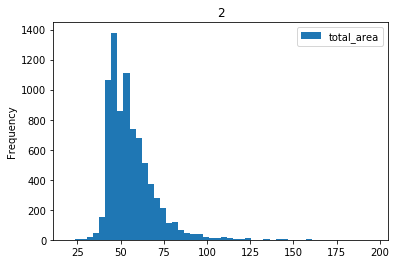

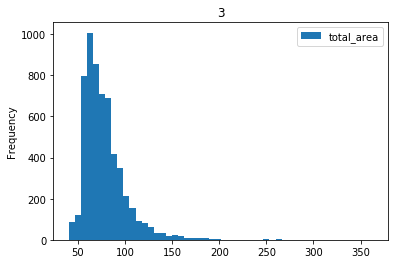

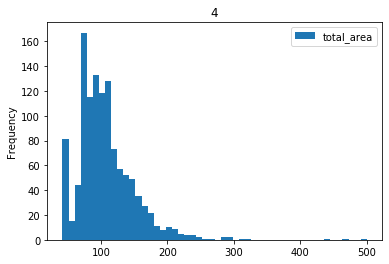

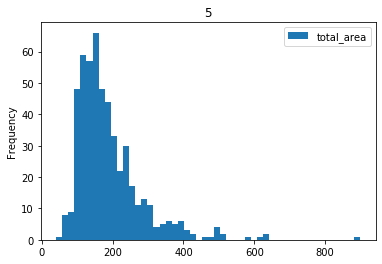

In [114]:
for rooms, group_data in data.groupby('rooms_new'):
    group_data.plot(y = 'total_area', kind = 'hist', title = rooms,  bins = 50)

Не может быть квартир менее 20 м2, отбросим эти строки, т.е. всего 27 значений. А также удалим строку со студией, равной 371 м2. Это квартира со свободной планировкой, у которой поэтому не указана комнатность, она искажает значения по категории.

In [115]:
data = data.query('total_area >= 20')
data = data.query('total_area != 371')
data.shape[0]

23671

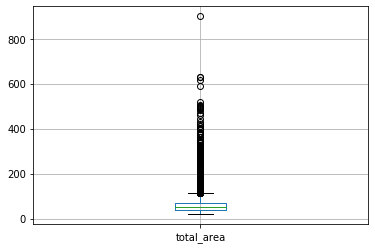

In [116]:
data.boxplot(['total_area'])

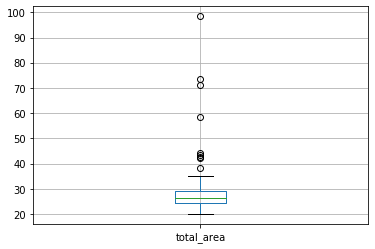

In [117]:
data1room = data.query('rooms_new == 0')
data1room.boxplot(['total_area'])

Построим гистограмму для цены квартир:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e677ee490>]],
      dtype=object)

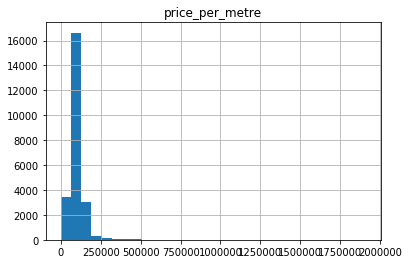

In [118]:
data.hist('price_per_metre', bins = 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e6773fa90>]],
      dtype=object)

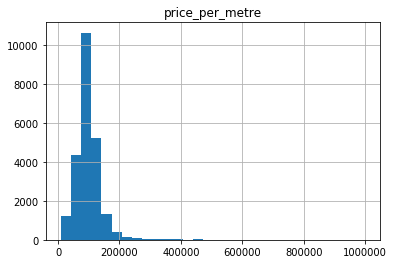

In [119]:
data.hist('price_per_metre', bins = 30, range=(9000, 1000000))

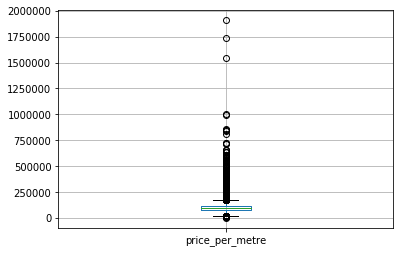

In [120]:
data.boxplot(['price_per_metre'])

In [121]:
data.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,
0,34375,231960,105042,107842.648
1,11000,848484,100000,100754.205
2,111,1542604,92796,95489.208
3,10507,1736842,88983,97150.694
4,13483,995983,92666,110331.160
5,14347,1907500,99642,134963.445
All,111,1907500,95000,99393.026


Удалим строку с выбывающим значением 111 руб./м2

In [122]:
data = data.query('price_per_metre > 10000')
data.shape[0]

23668

In [123]:
data.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,
0,34375,231960,105042,107842.648
1,11000,848484,100000,100754.205
2,10185,1542604,92812,95523.072
3,10507,1736842,88983,97150.694
4,13483,995983,92666,110331.160
5,14347,1907500,99642,134963.445
All,10185,1907500,95000,99404.877


Построим гистограмму для числа комнат:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e67668650>]],
      dtype=object)

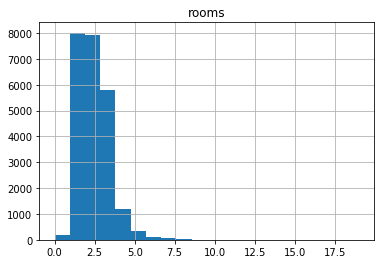

In [124]:
data.hist('rooms', bins = 20)

И отдельно гистограмму по укрупнённым типам комнатности:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e67542950>]],
      dtype=object)

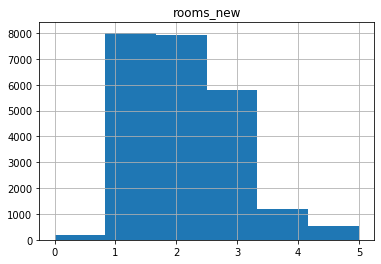

In [125]:
data.hist('rooms_new', bins = 6)

Построим гистрограмму по высоте потолков:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e69c6b110>]],
      dtype=object)

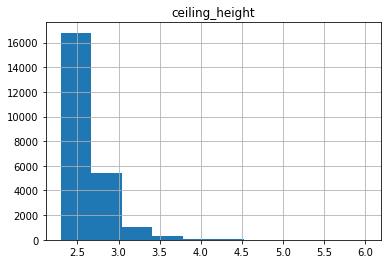

In [126]:
data.hist('ceiling_height', bins = 10)

#### Вывод:
Были рассчитаны Минимальные, максимальные, медианные, средние значения площади, цены, числа комнат и высоты потолков. И отброшены выдающиеся значения.


<a id="exposition"></a>
#### 4.2. Изучение времени продажи квартир

Изучим время продажи квартиры: построим гистограмму, рассчитаем среднее и медиану по типа квартир.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e6996ad90>]],
      dtype=object)

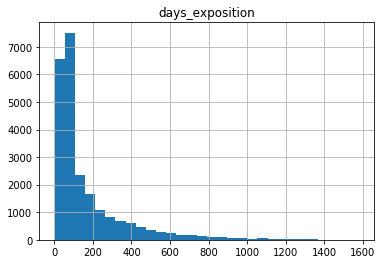

In [127]:
data.hist('days_exposition', bins = 30)

In [128]:
data['days_exposition'].describe()

count   23668.000
mean      169.472
std       206.588
min         1.000
25%        45.000
50%        95.000
75%       199.000
max      1580.000
Name: days_exposition, dtype: float64

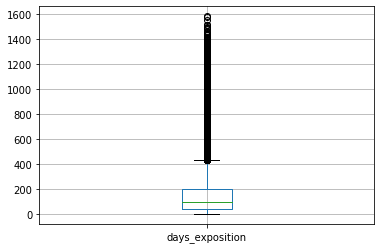

In [129]:
data.boxplot(['days_exposition'])

75% квартир продаются в течение 200 дней. Продажи, занимающие меньше месяца и более года редки.

In [130]:
data.pivot_table(index=['rooms_new'], values='days_exposition', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,days_exposition,days_exposition,days_exposition,days_exposition
rooms_new,,,,
0,3,931,55.000,109.020
1,2,1512,95.000,152.981
2,1,1580,95.000,163.147
3,3,1553,95.000,185.539
4,3,1512,102.500,222.014
5,4,1395,102.000,244.386
All,1,1580,95.000,169.472


В среднем студии продаются быстрее всего - за 1,5 месяца; однокомнатные, двухкомнатные, трёхкомнатные - за 3 месяца; крупные квартиры продаются дольше всего - более 3 месяцев, чего и следовало ожидать.

In [131]:
data.shape[0]

23668

Отфильтруем строки с временем экспозиции более 600 дней (это около 5% от всех данных). Будем считать их выбросами. Данные значения редки и некорректны.

In [132]:
data_normal_sold = data.query('days_exposition < 600')
data_normal_sold.shape[0]

22467

In [133]:
data_normal_sold.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new
count,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000,22467.000
mean,9.915,6443005.949,59.786,2.056,2.694,10.719,34.339,5.919,10.428,0.596,29901.895,19068.820,0.463,2814.116,0.582,2675.953,132.940,99107.530,2.574,2017.465,6.405,2.020,0.565,0.189,2.042
std,5.685,10785584.676,34.905,1.065,0.216,6.611,22.277,4.896,5.685,0.962,11337.025,11477.442,0.743,1671.938,0.877,1697.622,127.770,49876.112,1.791,0.956,3.485,0.511,0.103,0.074,0.998
min,0.000,430000.000,20.000,0.000,2.300,1.000,2.000,1.000,1.300,0.000,0.000,181.000,0.000,1.000,0.000,13.000,1.000,10185.000,0.000,2014.000,1.000,1.000,0.022,0.025,0.000
25%,6.000,3400000.000,40.000,1.000,2.600,5.000,18.700,2.000,7.100,0.000,21037.500,11082.000,0.000,604.000,0.000,645.000,45.000,76562.000,1.000,2017.000,3.000,2.000,0.491,0.133,1.000
50%,10.000,4600000.000,51.800,2.000,2.650,9.000,30.000,4.000,9.020,0.000,33200.000,15016.000,0.000,4000.000,0.000,4000.000,95.000,94995.000,3.000,2018.000,6.000,2.000,0.571,0.172,2.000
75%,14.000,6700000.000,69.000,3.000,2.700,16.000,42.000,8.000,11.700,1.000,34631.000,34247.000,1.000,4000.000,1.000,4000.000,170.000,113949.000,4.000,2018.000,10.000,2.000,0.633,0.238,3.000
max,50.000,763000000.000,900.000,19.000,6.000,60.000,417.396,33.000,122.457,5.000,84853.000,65952.000,3.000,4000.000,3.000,4000.000,599.000,1907500.000,6.000,2019.000,12.000,3.000,1.000,0.788,5.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e6a0c4150>]],
      dtype=object)

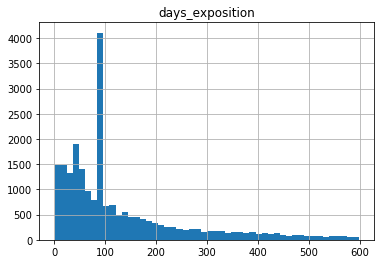

In [134]:
data_normal_sold.hist('days_exposition', bins = 50)

Доля быстрых продаж (со сроком экспозиции меньше месяца) - 15%. Проверим, как скорость продажи связана с уровнем цены.

In [135]:
data_fast_sold = data.query('days_exposition < 30')
data_fast_sold.shape[0]

3518

In [136]:
data_fast_sold.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean', 'count'])

,min,max,median,mean,count
,price_per_metre,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,,
0,54285,146757,105058.000,106545.980,51
1,15714,600000,100600.000,102604.742,1447
2,13207,303460,95000.000,96294.154,1161
3,12724,503875,88810.000,95403.268,716
4,26250,462745,87483.000,102613.404,109
5,33181,658436,91097.500,130356.853,34


In [137]:
data_normal_sold.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean', 'count'])

,min,max,median,mean,count
,price_per_metre,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,,
0,34375,231960,105058.000,108009.072,195
1,11000,848484,100000.000,100659.100,7686
2,10185,1542604,92781.000,95255.369,7576
3,10507,1736842,88888.000,96710.509,5469
4,13483,995983,92636.500,110028.063,1080
5,14347,1907500,99642.000,135632.347,461


Гипотеза не подтвердилась: медианная цена по этим квартирам примерно на том же уровне, что и в общей выборке. Рассмотрим отдельно квартиры со сроком экспозиции менее 10 дней (это чуть менее 5% от общей выборки).

In [138]:
data_too_fast_sold = data.query('days_exposition < 10')
data_too_fast_sold.shape[0]

1122

In [139]:
data_too_fast_sold.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean', 'count'])

,min,max,median,mean,count
,price_per_metre,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,,
0,54285,146757,97540.500,100322.667,18
1,18965,356413,101671.500,104457.638,472
2,16363,243055,93569.000,93454.706,374
3,12724,358974,88730.500,95762.761,222
4,41118,462745,87652.500,114961.615,26
5,43750,251801,99288.500,116859.200,10


По данным квартирам цена, как и ожидалось, ниже, чем в общей выборке. Отбросим данные значения.

In [140]:
data_normal_sold = data_normal_sold.query('days_exposition >= 10')
data_normal_sold.shape[0]

21345

In [141]:
data_normal_sold = data_normal_sold.query('price_per_metre < 500000')
data_normal_sold.shape[0]

21308

In [142]:
data_normal_sold.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new
count,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000,21308.000
mean,9.930,6265904.172,59.938,2.066,2.694,10.704,34.433,5.914,10.436,0.591,29939.245,19143.978,0.461,2815.172,0.582,2675.516,139.547,97991.653,2.570,2017.446,6.389,2.018,0.565,0.189,2.051
std,5.653,7676782.846,34.553,1.066,0.214,6.620,22.088,4.908,5.610,0.961,11315.662,11510.068,0.740,1671.422,0.876,1697.775,127.585,40757.604,1.789,0.961,3.487,0.514,0.103,0.074,0.999
min,0.000,430000.000,20.000,0.000,2.300,1.000,2.000,1.000,1.300,0.000,0.000,181.000,0.000,1.000,0.000,13.000,10.000,10185.000,0.000,2014.000,1.000,1.000,0.022,0.025,0.000
25%,6.000,3400000.000,40.000,1.000,2.600,5.000,18.800,2.000,7.100,0.000,21185.000,11087.750,0.000,606.750,0.000,645.000,52.000,76271.000,1.000,2017.000,3.000,2.000,0.491,0.133,1.000
50%,10.000,4600000.000,52.000,2.000,2.650,9.000,30.000,4.000,9.100,0.000,33200.000,15058.000,0.000,4000.000,0.000,4000.000,95.000,94822.500,3.000,2017.000,6.000,2.000,0.572,0.171,2.000
75%,14.000,6736700.000,69.192,3.000,2.700,16.000,42.200,8.000,11.700,1.000,34620.000,34567.250,1.000,4000.000,1.000,4000.000,179.000,113859.500,4.000,2018.000,10.000,2.000,0.633,0.238,3.000
max,50.000,420000000.000,900.000,19.000,5.800,60.000,417.396,32.000,112.000,5.000,84853.000,65952.000,3.000,4000.000,3.000,4000.000,599.000,491446.000,6.000,2019.000,12.000,3.000,1.000,0.788,5.000


##### Вывод:
В данном разделе было рассмотрено время продажи квартир. Продажа квартиры в среднем занимает 3 месяца. Студии продаются быстрее всего - за 1,5 месяца; однокомнатные, двухкомнатные, трёхкомнатные - за 3 месяца; крупные квартиры продаются дольше всего - более 3 месяцев. Значения со сроком экспозиции менее 10 дней и более 600 дней были из выборки удалены. Также были удалены квартиры со стоимостью  метра квадратного более 500000, чтобы они не оказывали влияния на дальнейшие результаты.

<a id="pricing"></a>
#### 4.3. Ценообразующие факторы

Рассмотрим факторы, влияющие на стоимость квартиры.

Построим график зависимости цены от площади квартиры и рассчитаем коэффициент корреляции для этих двух параметров:

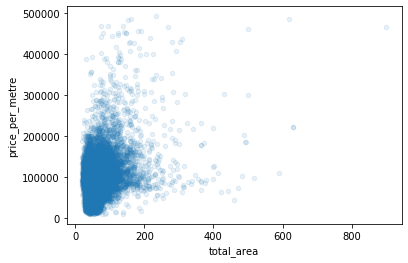

In [143]:
data_normal_sold.plot(x='total_area', y='price_per_metre', kind='scatter', alpha=0.1) 

In [144]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['total_area'])

0.27869727553018564

Построим график зависимости цены от количества комнат и рассчитаем коэффициент корреляции для этих двух параметров:

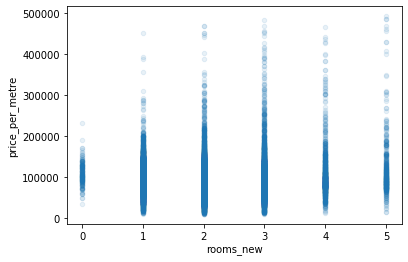

In [145]:
data_normal_sold.plot(x='rooms_new', y='price_per_metre', kind='scatter', alpha=0.1) 

In [146]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['rooms_new'])

0.019491903363084304

Построим график зависимости цены от удалённости от центра и рассчитаем коэффициент корреляции для этих двух параметров:

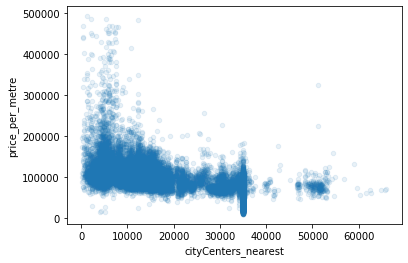

In [147]:
data_normal_sold.plot(x='cityCenters_nearest', y='price_per_metre', kind='scatter', alpha=0.1) 

In [148]:
data_normal_sold.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new
0,20,13000000,108.000,2019-03-07,3,2.700,16,51.000,8,False,False,False,25.000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,3,2019,3,Другой,2,0.472,0.231,3
1,7,3350000,40.400,2018-12-04,1,2.650,11,18.600,1,False,False,False,11.000,2,посёлок Шушары,12817,18603,0,4000,0,4000,81,82920,1,2018,12,Первый,1,0.460,0.272,1
2,10,5196000,56.000,2015-08-20,2,2.650,5,34.300,4,False,False,False,8.300,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,3,2015,8,Другой,2,0.612,0.148,2
3,0,64900000,159.000,2015-07-24,3,2.650,14,100.435,9,False,False,False,20.443,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,4,2015,7,Другой,2,0.632,0.129,3
4,2,10000000,100.000,2018-06-19,2,3.030,14,32.000,13,False,False,False,41.000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,1,2018,6,Другой,2,0.320,0.410,2


In [149]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['cityCenters_nearest'])

-0.5781337805658306

Есть достаточно сильно выраженная обратная зависимость: чем ближе квартира к центру, тем она дороже.

Построим график зависимости цены от этажа и рассчитаем коэффициент корреляции для этих двух параметров (для справки: ранее мы применили следующую кодировку: 1 -первый этаж, 3 - последний, 2 - другой):

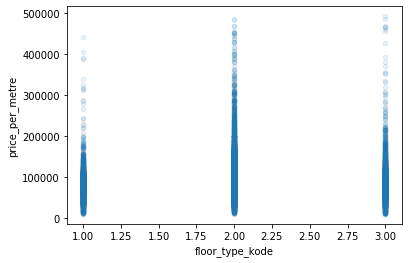

In [150]:
data_normal_sold.plot(x='floor_type_kode', y='price_per_metre', kind='scatter', alpha=0.1) 

In [151]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['floor_type_kode'])

0.04541719601264184

Построим график зависимости цены от дня недели даты размещения и рассчитаем коэффициент корреляции для этих двух параметров

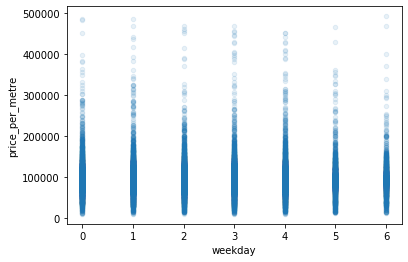

In [152]:
data_normal_sold.plot(x='weekday', y='price_per_metre', kind='scatter', alpha=0.1) 

In [153]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['weekday'])

-0.01103494635706453

Нет зависимости цены от дня недели публикации объявления.

Построим график зависимости цены от года публикации объявления и рассчитаем коэффициент корреляции для этих двух параметров

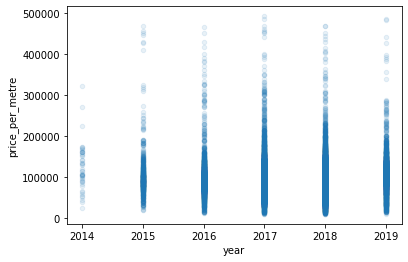

In [154]:
data_normal_sold.plot(x='year', y='price_per_metre', kind='scatter', alpha=0.1) 

In [155]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['year'])

0.03280558878770824

Построим график зависимости цены от месяца публикации объявления и рассчитаем коэффициент корреляции для этих двух параметров

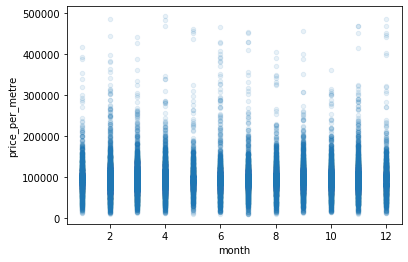

In [156]:
data_normal_sold.plot(x='month', y='price_per_metre', kind='scatter', alpha=0.1) 

In [157]:
data_normal_sold['price_per_metre'].corr(data_normal_sold['month'])

-0.006314253263443484

Построим матрицу корреляций для наших данных.

In [158]:
data_normal_sold.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new
total_images,1.000,0.115,0.113,0.098,0.049,0.012,0.097,0.030,0.014,-0.033,-0.022,0.102,0.045,-0.011,-0.071,0.036,-0.040,0.012,-0.016,-0.018,0.142,-0.012,0.145,0.008,0.030,0.004,-0.038,0.104
last_price,0.115,1.000,0.773,0.444,0.345,0.013,0.685,0.043,0.020,-0.038,-0.016,0.579,0.010,-0.066,-0.336,0.227,-0.198,0.235,-0.198,0.059,0.651,-0.006,-0.025,0.004,0.061,0.016,-0.122,0.405
total_area,0.113,0.773,1.000,0.763,0.381,-0.070,0.944,-0.024,0.015,-0.084,-0.041,0.610,0.015,-0.053,-0.260,0.189,-0.163,0.193,-0.158,0.086,0.279,-0.006,-0.046,0.005,0.061,0.164,-0.347,0.720
rooms,0.098,0.444,0.763,1.000,0.238,-0.227,0.831,-0.155,-0.000,-0.177,-0.083,0.262,-0.010,-0.072,-0.194,0.150,-0.135,0.115,-0.096,0.073,0.029,-0.003,-0.026,-0.001,0.023,0.501,-0.627,0.978
ceiling_height,0.049,0.345,0.381,0.238,1.000,-0.078,0.359,-0.042,0.055,0.006,-0.004,0.323,-0.039,-0.096,-0.280,0.241,-0.200,0.211,-0.164,0.064,0.305,-0.022,-0.031,-0.001,0.045,0.000,-0.013,0.225
floors_total,0.012,0.013,-0.070,-0.227,-0.078,1.000,-0.157,0.680,-0.025,0.089,0.052,0.161,0.173,0.067,-0.107,-0.152,0.123,-0.044,-0.005,-0.034,0.209,0.015,0.000,0.015,-0.011,-0.356,0.355,-0.232
living_area,0.097,0.685,0.944,0.831,0.359,-0.157,1.000,-0.092,0.013,-0.063,-0.028,0.443,-0.007,-0.070,-0.247,0.197,-0.167,0.175,-0.142,0.080,0.197,-0.004,-0.038,-0.000,0.053,0.427,-0.485,0.792
floor,0.030,0.043,-0.024,-0.155,-0.042,0.680,-0.092,1.000,-0.013,0.051,0.035,0.131,0.169,0.048,-0.074,-0.103,0.085,-0.026,-0.006,-0.026,0.172,0.012,0.000,0.018,0.308,-0.260,0.247,-0.161
is_apartment,0.014,0.020,0.015,-0.000,0.055,-0.025,0.013,-0.013,1.000,-0.004,-0.002,0.041,0.032,0.021,0.002,0.009,0.005,0.018,-0.022,-0.009,0.029,-0.010,0.022,-0.006,0.008,-0.002,0.016,-0.002
studio,-0.033,-0.038,-0.084,-0.177,0.006,0.089,-0.063,0.051,-0.004,1.000,0.486,0.013,0.044,-0.015,0.025,-0.038,0.041,-0.012,0.006,-0.026,0.024,0.002,-0.003,0.015,-0.006,0.107,0.262,-0.188


##### Вывод:
На цену метра квадратного большое влияние оказывает расстояние до центра города, кроме того влияние оказывают такие факторы, как метраж квартиры, площадь кухни, высота потолков, наличие парков/водоёмов поблизости, этажность дома.

<a id="localty"></a>
#### 4.4. Цены по населённым пунктам

Определим 10 населённых пунктов с наибольшим числом объявлений, определим среднюю цену квадратного метра в этих населённых пунктах.

In [159]:
data_normal_sold_pivot = data_normal_sold.pivot_table(index=['locality_name'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean', 'count'])
data_normal_sold_pivot.columns = ['min', 'max', 'median', 'mean', 'count']
top10_localties = data_normal_sold_pivot.sort_values(by = 'count', ascending = False).head(10)
top10_localties

,min,max,median,mean,count
locality_name,,,,,
Санкт-Петербург,15345,491446,104687.000,113122.136,14065
посёлок Мурино,51460,138580,86171.000,86007.959,468
посёлок Шушары,47700,147826,76986.000,78761.811,408
Всеволожск,31400,136423,65811.000,67356.929,364
Пушкин,59836,256521,99744.000,102674.462,329
Колпино,47957,125000,74375.000,75158.854,309
посёлок Парголово,39205,138522,91040.000,89642.667,297
Гатчина,10507,146315,67695.000,68794.828,273
деревня Кудрово,54160,142857,91803.000,92605.799,259


In [160]:
top10_localties.sort_values(by = 'mean', ascending = False)

,min,max,median,mean,count
locality_name,,,,,
Санкт-Петербург,15345,491446,104687.000,113122.136,14065
Пушкин,59836,256521,99744.000,102674.462,329
деревня Кудрово,54160,142857,91803.000,92605.799,259
посёлок Парголово,39205,138522,91040.000,89642.667,297
посёлок Мурино,51460,138580,86171.000,86007.959,468
посёлок Шушары,47700,147826,76986.000,78761.811,408
Колпино,47957,125000,74375.000,75158.854,309
Гатчина,10507,146315,67695.000,68794.828,273
Всеволожск,31400,136423,65811.000,67356.929,364


##### Вывод:
Как и следовало ожидать, максимальная цена квадратного метра в Санкт-Петербурге, минимальная из топ10 локаций-пригородов - в Выборге.

<a id="centre"></a>
#### 4.5. Квартиры в центре города

Выделим квартиры только в Санкт-Петербурге. Создадим столбец с расстоянием до центра города в км и выделим сегмент квартир в центре города.

In [161]:
data_spb = data_normal_sold.query('locality_name == "Санкт-Петербург"')
data_spb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14065 entries, 0 to 23694
Data columns (total 31 columns):
total_images            14065 non-null uint8
last_price              14065 non-null uint32
total_area              14065 non-null float64
first_day_exposition    14065 non-null datetime64[ns]
rooms                   14065 non-null uint8
ceiling_height          14065 non-null float64
floors_total            14065 non-null uint8
living_area             14065 non-null float64
floor                   14065 non-null uint8
is_apartment            14065 non-null bool
studio                  14065 non-null bool
open_plan               14065 non-null bool
kitchen_area            14065 non-null float64
balcony                 14065 non-null uint8
locality_name           14065 non-null object
airports_nearest        14065 non-null uint32
cityCenters_nearest     14065 non-null uint32
parks_around3000        14065 non-null uint8
parks_nearest           14065 non-null uint16
ponds_around3000 

In [162]:
data_spb['cityCenters_km'] = (data_spb['cityCenters_nearest']/1000).astype('uint16')
data_spb.sample(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,cityCenters_km
12966,3,3500000,28.800,2018-07-16,1,2.650,9,16.000,2,False,False,False,6.100,0,Санкт-Петербург,36294,10652,0,4000,0,4000,95,121527,0,2018,7,Другой,2,0.556,0.212,1,10
9585,6,5200000,49.000,2017-04-17,1,2.650,18,14.100,7,False,False,False,19.600,2,Санкт-Петербург,32581,8720,0,4000,1,431,273,106122,0,2017,4,Другой,2,0.288,0.400,1,8
19868,19,12400000,106.000,2018-08-07,3,3.000,6,73.400,5,False,False,False,12.700,0,Санкт-Петербург,22148,4291,1,679,0,4000,39,116981,1,2018,8,Другой,2,0.692,0.120,3,4
21790,6,3190000,44.000,2017-01-25,1,2.700,16,20.000,4,False,False,False,14.000,1,Санкт-Петербург,18357,21796,0,4000,1,982,45,72500,2,2017,1,Другой,2,0.455,0.318,1,21
4452,7,6700000,62.000,2015-07-08,4,2.650,9,46.800,2,False,False,False,8.300,0,Санкт-Петербург,31681,4511,2,198,0,4000,433,108064,2,2015,7,Другой,2,0.755,0.134,4,4


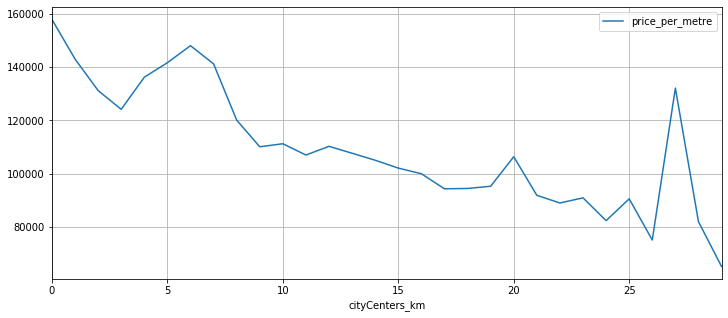

In [163]:
(data_spb     
     .pivot_table(index='cityCenters_km', values='price_per_metre')
     .plot(grid=True, figsize=(12, 5))
) 

In [164]:
(data_spb     
     .pivot_table(index='cityCenters_km', values='price_per_metre')
)

,price_per_metre
cityCenters_km,
0,157841.429
1,142999.787
2,131182.275
3,124152.742
4,136194.504
5,141632.029
6,148009.485
7,141196.762
8,120123.402


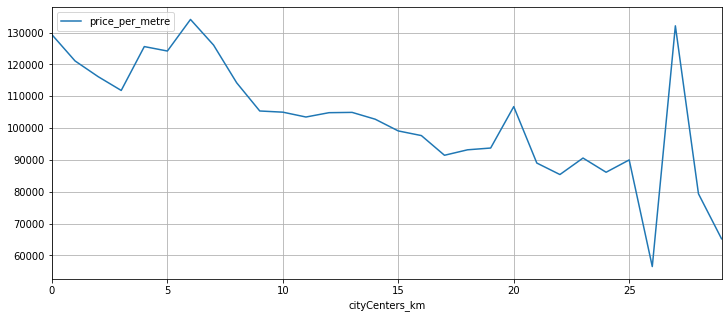

In [165]:
(data_spb     
     .pivot_table(index='cityCenters_km', values='price_per_metre', aggfunc = 'median')
     .plot(grid=True, figsize=(12, 5))
) 

In [166]:
(data_spb     
     .pivot_table(index='cityCenters_km', values='price_per_metre', aggfunc = 'median')
)

,price_per_metre
cityCenters_km,
0,129331.000
1,121092.000
2,116158.000
3,111821.000
4,125598.000
5,124200.000
6,134117.000
7,126063.000
8,114229.000


Исходя из средней цены по равноудалённым от центра квартирам отнесём к сегменту квартир в центре города объекты с расстоянием до центра города менее 7 км.

In [167]:
data_centre = data_spb.query('cityCenters_km <= 7')
data_centre.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,cityCenters_km
count,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000,3199.000
mean,10.337,13302242.241,90.935,2.801,2.922,7.246,53.945,4.286,14.108,0.326,24671.277,4733.943,1.013,1669.434,1.264,1483.718,160.176,138162.305,2.530,2017.326,6.402,2.061,0.583,0.172,2.719,4.237
std,5.992,16223097.945,58.692,1.427,0.358,4.006,37.869,3.117,8.862,0.765,4324.095,1750.898,0.930,1693.996,1.082,1613.022,136.910,61121.696,1.735,1.013,3.434,0.533,0.111,0.081,1.172,1.744
min,0.000,1800000.000,20.000,0.000,2.400,2.000,2.000,1.000,2.000,0.000,12388.000,181.000,0.000,9.000,0.000,22.000,10.000,15345.000,0.000,2014.000,1.000,1.000,0.022,0.025,0.000,0.000
25%,6.000,6550000.000,56.000,2.000,2.650,5.000,31.000,2.000,9.000,0.000,21765.500,3625.500,0.000,361.000,0.000,325.000,71.000,100000.000,1.000,2017.000,3.000,2.000,0.516,0.118,2.000,3.000
50%,10.000,9000000.000,77.100,3.000,2.800,6.000,45.400,4.000,11.700,0.000,24329.000,4831.000,1.000,603.000,1.000,636.000,95.000,123203.000,3.000,2017.000,6.000,2.000,0.596,0.152,3.000,4.000
75%,15.000,13992250.000,107.000,3.000,3.100,9.000,65.150,5.000,16.200,0.000,27179.000,5955.000,2.000,4000.000,2.000,4000.000,217.000,154249.500,4.000,2018.000,9.000,2.000,0.660,0.204,3.000,5.000
max,50.000,420000000.000,900.000,19.000,5.800,25.000,417.396,25.000,112.000,5.000,39763.000,7998.000,3.000,4000.000,3.000,4000.000,599.000,491446.000,6.000,2019.000,12.000,3.000,0.983,0.637,5.000,7.000


Проанализируем сегмент квартир в центре.
Построим гистограмму для площади квартир в центре. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e674acc10>]],
      dtype=object)

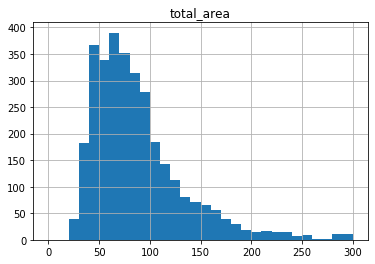

In [168]:
data_centre.hist('total_area', bins = 30, range=(0, 300))

In [169]:
data_centre.pivot_table(index=['rooms_new'], values='total_area', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,total_area,total_area,total_area,total_area
rooms_new,,,,
0,21.000,98.400,32.350,41.107
1,20.000,190.000,41.700,43.240
2,20.000,146.000,61.150,64.558
3,43.000,363.100,86.000,93.380
4,60.000,500.000,112.000,122.783
5,87.400,900.000,168.000,195.715
All,20.000,900.000,77.100,90.935


По всем типам комнатности квартиры в центре крупнее квартир по всем локациям.
Построим гистаграмму цены квартир в центре.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e673e6450>]],
      dtype=object)

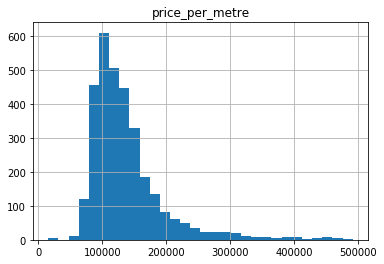

In [170]:
data_centre.hist('price_per_metre', bins = 30)

In [171]:
data_centre.pivot_table(index=['rooms_new'], values='price_per_metre', aggfunc=['min', 'max', 'median', 'mean'], margins=True)

,min,max,median,mean
,price_per_metre,price_per_metre,price_per_metre,price_per_metre
rooms_new,,,,
0,100543,231960,136078,145391.857
1,16842,450000,141860,148973.220
2,59523,468750,125000,138461.200
3,49019,467553,116279,136036.408
4,15861,464998,108790,134020.158
5,15345,491446,106361,133203.372
All,15345,491446,123203,138162.305


По всем типам комнатности цена метра квадратного в данном сегменте значительно выше.
Построим гистаграмму по типам комнатности.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e672d8f10>]],
      dtype=object)

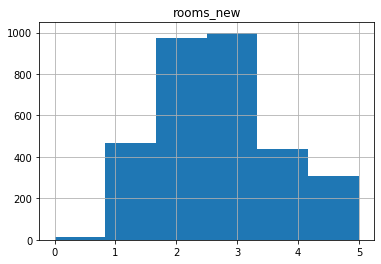

In [172]:
data_centre.hist('rooms_new', bins = 6)

В сегменте квартир в центре выше доля многокомнатных квартир и ниже - однокомнатных.
Построим гистрограмму по высоте потолков:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e672941d0>]],
      dtype=object)

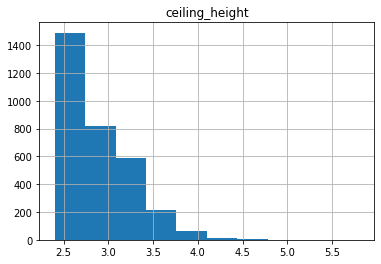

In [173]:
data_centre.hist('ceiling_height', bins = 10)

В данном сегменте есть предложения по квартирам с высокими потолками, а также по нестандартным квартирам.
Теперь выделим основные ценообразующие факторы для квартир, расположенных в центре города.
Построим матрицу корреляций.

In [174]:
data_centre.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_metre,weekday,year,month,floor_type_kode,living_area_to_all,kitchen_area_to_all,rooms_new,cityCenters_km
total_images,1.000,0.113,0.080,0.044,0.072,-0.011,0.058,0.014,0.013,-0.042,-0.037,0.113,0.030,0.037,0.018,0.050,-0.036,-0.009,-0.011,-0.036,0.153,0.011,0.140,-0.002,0.033,-0.040,0.032,0.053,0.018
last_price,0.113,1.000,0.769,0.417,0.156,0.081,0.666,0.160,0.034,-0.031,-0.001,0.574,0.047,0.132,-0.011,0.103,-0.036,0.078,-0.048,0.061,0.641,0.005,-0.035,0.001,0.109,-0.011,-0.116,0.370,-0.017
total_area,0.080,0.769,1.000,0.750,0.237,-0.008,0.946,0.110,0.011,-0.056,-0.018,0.587,0.000,0.042,-0.106,0.091,-0.036,0.015,0.007,0.081,0.206,0.003,-0.046,-0.012,0.136,0.149,-0.331,0.687,-0.113
rooms,0.044,0.417,0.750,1.000,0.225,-0.180,0.801,-0.045,0.011,-0.130,-0.024,0.291,-0.080,-0.038,-0.174,0.091,-0.061,-0.028,0.037,0.069,-0.059,-0.004,-0.031,-0.007,0.102,0.415,-0.518,0.933,-0.179
ceiling_height,0.072,0.156,0.237,0.225,1.000,-0.271,0.259,-0.158,0.002,0.030,-0.009,0.129,-0.082,-0.049,-0.248,0.150,-0.106,0.014,0.040,0.050,0.054,-0.051,0.063,-0.014,0.050,0.131,-0.108,0.234,-0.247
floors_total,-0.011,0.081,-0.008,-0.180,-0.271,1.000,-0.100,0.684,-0.010,0.029,0.026,0.105,0.366,0.128,0.387,-0.238,0.220,-0.032,-0.055,-0.015,0.185,0.037,-0.037,0.016,-0.019,-0.322,0.187,-0.196,0.382
living_area,0.058,0.666,0.946,0.801,0.259,-0.100,1.000,0.031,0.013,-0.044,-0.008,0.443,-0.037,0.012,-0.142,0.111,-0.053,0.009,0.016,0.072,0.119,0.000,-0.038,-0.011,0.133,0.404,-0.450,0.744,-0.148
floor,0.014,0.160,0.110,-0.045,-0.158,0.684,0.031,1.000,-0.009,0.003,0.003,0.132,0.301,0.083,0.261,-0.155,0.146,-0.040,-0.021,-0.012,0.167,0.034,-0.026,0.021,0.376,-0.194,0.062,-0.054,0.256
is_apartment,0.013,0.034,0.011,0.011,0.002,-0.010,0.013,-0.009,1.000,-0.003,-0.002,0.077,0.010,-0.009,-0.056,0.046,-0.019,0.043,-0.028,-0.032,0.059,-0.030,0.000,-0.007,-0.019,0.016,0.048,0.004,-0.056
studio,-0.042,-0.031,-0.056,-0.130,0.030,0.029,-0.044,0.003,-0.003,1.000,0.325,0.017,0.015,-0.020,0.021,-0.026,0.033,-0.007,-0.015,-0.031,0.008,-0.001,-0.003,0.013,-0.017,0.065,0.186,-0.154,0.021


In [175]:
data_centre['price_per_metre'].corr(data_centre['total_area'])

0.2058932825728744

In [176]:
data_centre['price_per_metre'].corr(data_centre['rooms_new'])

-0.0681105244878435

In [177]:
data_centre['price_per_metre'].corr(data_centre['cityCenters_nearest'])

0.04853026733205403

In [178]:
data_centre['price_per_metre'].corr(data_centre['floor_type_kode'])

0.050364297990907685

In [179]:
data_centre['price_per_metre'].corr(data_centre['weekday'])

0.016504400100944658

In [180]:
data_centre['price_per_metre'].corr(data_centre['year'])

0.019762005204064986

In [181]:
data_centre['price_per_metre'].corr(data_centre['month'])

-0.017894794142958734

In [182]:
data_centre['price_per_metre'].corr(data_centre['ceiling_height'])

0.053735260792919404

	total_area	ceiling_height	floors_total	living_area	floor	kitchen_area	balcony	airports_nearest	cityCenters_nearest	parks_around3000	ponds_around3000
К  корр для всей выборки	0.279	0.305	0.209	0.197	0.172	0.401	0.028	-0.119	-0.578	0.312	0.319
К корр для центра	0.206	0.054	0.185	0.119	0.167	0.354	0.140	0.202	0.049	0.126	0.117
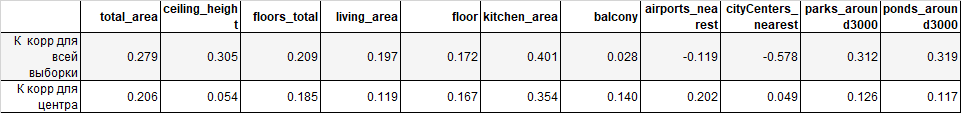

##### Вывод:
В сегменте квартир в центре выше доля многокомнатных квартир. Квартиры в центре города на 48% больше по площади, чем квартиры по всей выборке. Цена квартир в центре в среднем выше на 30%. В сегменте есть предложения по квартирам с высокими потолками. В целом квартиры в центре - это сегмент элитного жилья.
Коэффициент корреляции цены от площади квартиры для данного сегмента почти такой же, как и для общей выборки. Коэффициент корреляции цены от расстояния до центра очень низкий, т.к. в выборке уже содержатся только квартиры, расположенные в центре города. По квартирам в центре нет зависимости цены от высоты потолков, т.к. все потолки достаточной высоты. Как и для всей выборки, важна площадь кухни. Появляется зависимость цены от наличия балкона и становится более важной доступность аэропорта. При этом парки/пруды поблизости оказывают меньшее влияние на цену квартир в центре по сравнению со всей выборкой.

<a id="summary"></a>
### 5. Общий вывод

В ходе проекта были проанализированы основные факторы, влияющие на цену объектов недвижимости и сделаны следующие выводы:
- Продажа квартиры в среднем занимает 3 месяца. Студии продаются быстрее всего - за 1,5 месяца; однокомнатные, двухкомнатные, трёхкомнатные - за 3 месяца; крупные квартиры продаются дольше всего - более 3 месяцев. Значения со сроком экспозиции менее 10 дней и более 600 дней редки.
- На цену метра квадратного большое влияние оказывает расстояние до центра города, кроме того влияние оказывают такие факторы, как метраж квартиры, площадь кухни, высота потолков, наличие парков/водоёмов поблизости, этажность дома.
- Максимальная цена квадратного метра в Санкт-Петербурге, минимальная из топ10 локаций-пригородов - в Выборге.
- В элитном сегменте квартир в центре города выше доля многокомнатных квартир. Квартиры в центре города на 48% больше по площади, чем квартиры по всей выборке. Цена квартир в центре в среднем выше на 30%. В сегменте есть предложения по квартирам с высокими потолками. Коэффициент корреляции цены от площади квартиры для данного сегмента почти такой же, как и для общей выборки. Коэффициент корреляции цены от расстояния до центра очень низкий, т.к. в выборке уже содержатся только квартиры, расположенные в центре города. По квартирам в центре нет зависимости цены от высоты потолков, т.к. все потолки достаточной высоты. Как и для всей выборки, важна площадь кухни. Появляется зависимость цены от наличия балкона и становится более важной доступность аэропорта. При этом парки/пруды поблизости оказывают меньшее влияние на цену квартир в центре по сравнению со всей выборкой.